In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)



subset_colors = [cmap(0), cmap(5), cmap(1), cmap(3), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

no_oblique_subset_colors = [cmap(0), cmap(5), cmap(1), cmap(6), cmap(7)]
no_oblique_cmap_subset = ListedColormap(no_oblique_subset_colors)

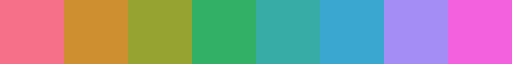

In [58]:
cmap

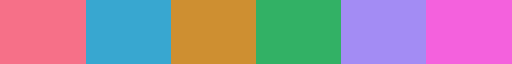

In [59]:
cmap_subset

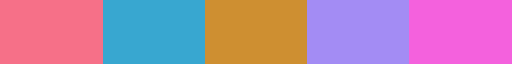

In [56]:
no_oblique_cmap_subset

### Coverage-Cost Experiments

In [71]:
fname = "../data/experiments/climate/coverage_comparison_exp.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2, 3], index_col=0)

In [46]:
experiment_df['normalized-clustering-cost']

Forest                       Forest-Depth-IMM                        \
       Forest     KMeans        IMM Forest-Depth-IMM     KMeans        IMM   
            0          0          0                0          0          0   
0   10.340717  10.314691  10.839924        11.258664  11.246629  11.844835   
1   10.340717  10.314691  10.839924        11.258664  11.246629  11.844835   
2   10.340717  10.314691  10.839924        11.258664  11.246629  11.844835   
3   10.769987  10.733983  11.413382        11.258664  11.246629  11.844835   
4   11.103925  10.897264  11.429366        11.258664  11.246629  11.844835   
5   11.048755  10.872323  11.374146        11.258664  11.246629  11.844835   
6   11.048755  10.872323  11.374146        11.640126  11.587713  12.177978   
7   11.370800  11.106726  11.585543        11.652035  11.555977  12.116513   
8   11.923440  11.397493  11.995907        11.793100  11.592351  12.214902   
9   12.172887  11.485642  12.121542        11.763204  11.530302  12.189579   
10  14.360709  11.660925  12.302270        13.588147  11.660925  12.302270   

          SVM                     IMM-outliers  ...     Forest  \
          SVM    KMeans       IMM IMM-outliers  ...        IMM   
            0         0         0            0  ...         99   
0   10.959874  8.727444  9.207879     6.989766  ...  11.188235   
1   10.959874  8.727444  9.207879     7.359984  ...  11.188235   
2   11.139453  8.917473  9.364632     8.052159  ...  11.188235   
3   11.139453  8.917473  9.364632     8.589182  ...  11.298887   
4         NaN       NaN       NaN     9.699846  ...  11.298887   
5         NaN       NaN       NaN    10.254943  ...  11.298887   
6         NaN       NaN       NaN    10.643991  ...  11.298887   
7         NaN       NaN       NaN    11.181563  ...  11.617282   
8         NaN       NaN       NaN    11.626533  ...  12.051837   
9         NaN       NaN       NaN    11.955571  ...  12.056279   
10        NaN       NaN       NaN    12.302270  ...        NaN   

   Forest-Depth-IMM                              SVM                        \
   Forest-Depth-IMM     KMeans        IMM        SVM     KMeans        IMM   
                 99         99         99         99         99         99   
0         11.066903  11.054822  11.416418  14.519704  11.929975  12.153049   
1         11.066903  11.054822  11.416418        NaN        NaN        NaN   
2         11.066903  11.054822  11.416418        NaN        NaN        NaN   
3         11.066903  11.054822  11.416418        NaN        NaN        NaN   
4         11.066903  11.054822  11.416418        NaN        NaN        NaN   
5         11.066903  11.054822  11.416418        NaN        NaN        NaN   
6         11.580457  11.506459  12.227927        NaN        NaN        NaN   
7         11.444576  11.311552  11.926828        NaN        NaN        NaN   
8         11.848384  11.629322  12.162752        NaN        NaN        NaN   
9         12.052815  11.593727  12.251674        NaN        NaN        NaN   
10              NaN        NaN        NaN        NaN        NaN        NaN   

   IMM-outliers                        
   IMM-outliers     KMeans        IMM  
             99         99         99  
0      6.989766   6.989766   7.130457  
1      7.359984   7.359984   7.625123  
2      8.052159   7.938571   8.475192  
3      8.589182   8.322171   8.993908  
4      9.699846   9.304712   9.941827  
5     10.254943   9.687795  10.333735  
6     10.643991  10.015881  10.771381  
7     11.181563  10.575106  11.331596  
8     11.626533  10.980449  11.727522  
9     11.955571  11.240816  11.955571  
10    12.302270  11.660925  12.302270  

[11 rows x 1200 columns]

In [72]:
# Computing statistics:
grouped = experiment_df.T.groupby(level = [0,1,2])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [73]:
mean_df['silhouette']['SVM']

,IMM,KMeans,SVM
0,0.207798,0.210696,0.259839
1,0.219915,0.223879,0.244276
2,0.223082,0.231460,0.229300
3,0.227509,0.240627,0.234243
4,0.221719,0.242976,0.230843
5,0.232611,0.245311,0.250703
6,NaN,NaN,NaN
7,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN


In [29]:
table_df = mean_df.iloc[-3,:].to_frame()
table_df

8
clustering-cost              Forest           Forest            3755.895179
                                              IMM               3774.326853
                                              KMeans            3577.349867
                             Forest-Depth-IMM Forest-Depth-IMM  3697.019872
                                              IMM               3813.698987
...                                                                     ...
weighted-average-rule-length IMM-outliers     IMM-outliers         3.715116
                                              KMeans                    NaN
                             SVM              IMM                  3.645349
                                              KMeans                    NaN
                                              SVM                  1.000000

[84 rows x 1 columns]

### Plotting

In [48]:
colormap = cmap_subset

In [ ]:
#colormap = no_oblique_cmap_subset
colormap = cmap_subset
#baseline_list = ['KMeans', 'IMM']
baseline_list = []
module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]

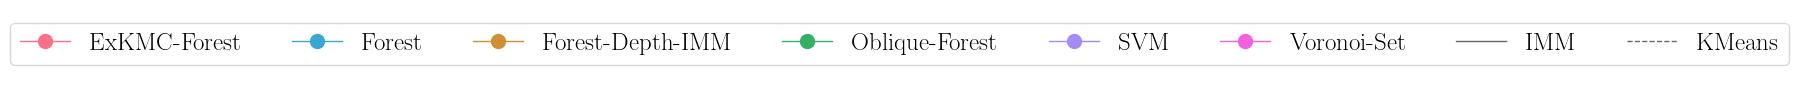

In [167]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="IMM",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="KMeans",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.axis('off')
plt.savefig('../figures/coverage/legend.png', bbox_inches = 'tight', dpi = 300)

In [36]:
normalize = mean_df['clustering-cost']['Forest']['KMeans'].iloc[-1]

<Axes: >

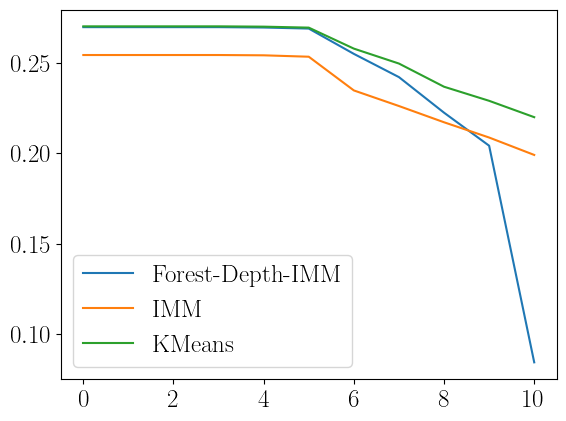

In [76]:
mean_df['silhouette']['Forest-Depth-IMM'].plot()

(0.49, 1.01)

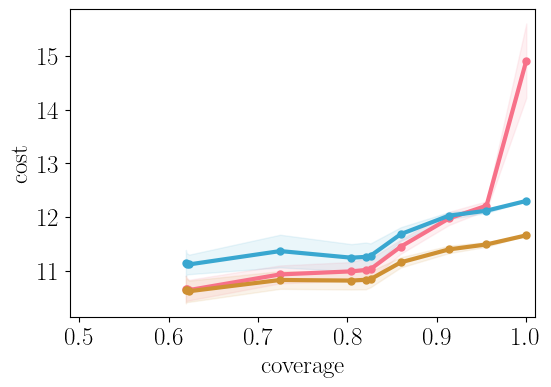

In [60]:
fname = None
#fname = '../figures/coverage/digits.png'
experiment_plotter(
    mean_df['normalized-clustering-cost']['Forest'],
    std_df['normalized-clustering-cost']['Forest'],
    domain_df = mean_df['coverage']['Forest'],
    xlabel = 'coverage',
    ylabel = 'cost',
    cmap = colormap,
    #baseline_list = ['KMeans', 'IMM'],
    baseline_list = [],
    legend = False,
    filename = fname,
)
plt.xlim(0.49,1.01)
#plt.ylim(10,14)

In [61]:
mean_df['coverage']['Forest']

,Forest,IMM,KMeans
0,0.619273,0.619273,0.619273
1,0.620058,0.620058,0.620058
2,0.622820,0.622820,0.622820
3,0.724767,0.724767,0.724767
4,0.804360,0.804360,0.804360
5,0.820523,0.820523,0.820523
6,0.825756,0.825756,0.825756
7,0.859622,0.859622,0.859622
8,0.913459,0.913459,0.913459
9,0.955465,0.955465,0.955465


(10.0, 14.0)

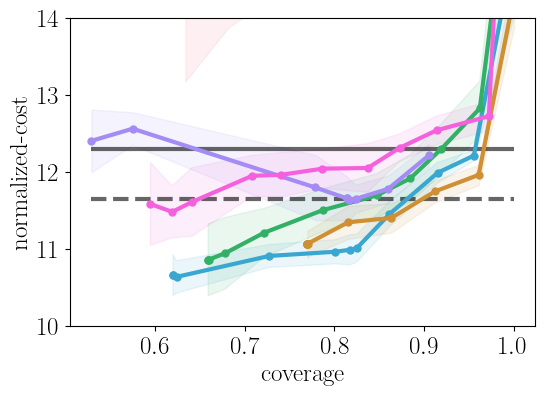

In [147]:
fname = None
#fname = '../figures/coverage/fashion.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    domain_df = mean_df['coverage'],
    xlabel = 'coverage',
    ylabel = 'normalized-cost',
    cmap = colormap,
    baseline_list = ['KMeans', 'IMM'],
    legend = False,
    filename = fname,
)
plt.ylim(10,14)

In [17]:
mean_df['distance-ratio']

,ExKMC-Forest,Forest,Forest-Depth-5,IMM,KMeans,SVM-Forest,Voronoi-Set
0,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
1,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
2,inf,1.613986,1.495841,1.594826,1.596493,1.749947,1.592836
3,inf,1.599610,1.495841,1.594826,1.596493,1.680446,1.592836
4,inf,1.590175,1.495841,1.594826,1.596493,1.625645,1.588021
5,inf,1.584477,1.495841,1.594826,1.596493,1.605630,1.571792
6,inf,1.544779,1.547680,1.594826,1.596493,1.574870,1.548586
7,inf,1.521701,1.546777,1.594826,1.596493,1.514120,1.506670
8,inf,1.498935,1.512124,1.594826,1.596493,1.391058,1.488403
9,inf,1.499270,1.455912,1.594826,1.596493,NaN,1.427247


### Covered Cost

In [53]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

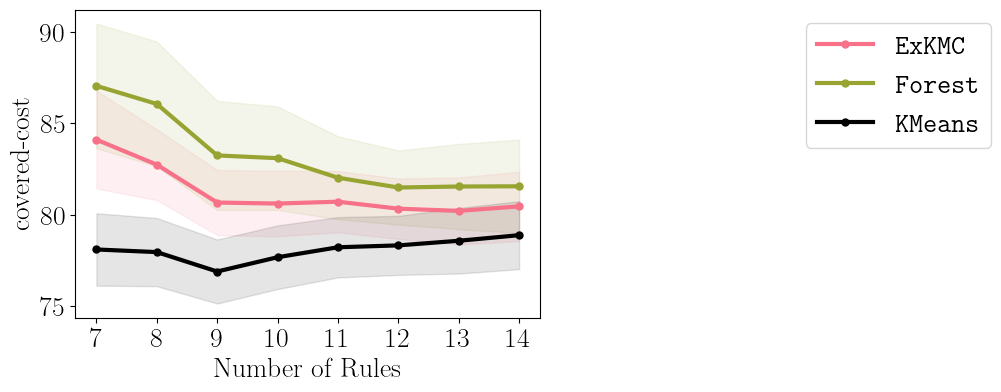

In [61]:
covered_cost_colors = [cmap(0), cmap(2), 'black']
covered_cost_colormap = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_covered_cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [59]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate_depth_5.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

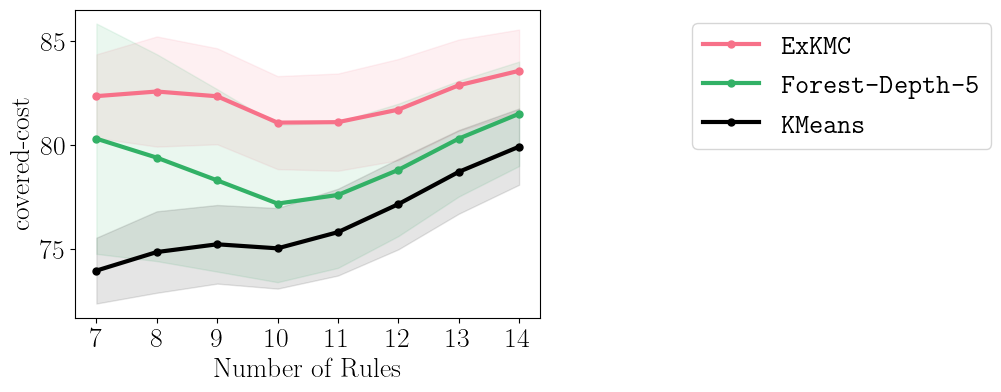

In [62]:
covered_cost_colors = [cmap(0), cmap(3), 'black']
covered_cost_colormap2 = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_d5_covered_cost.png'
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap2,
    legend = True,
    filename = fname,
    baseline_list = []
)